# Import libraries

In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from dirrac.data.synthetic_data import DataSynthesizer
from dirrac.classifier.logistic import logistic_classifier
from dirrac.optim.opt import Optimization
from utils import pad_ones

[ENV WARNING] deactivate virtualenv to allow for testing Actionable Recourse


In [2]:
# Matplotlib config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

# Synthesize data and train classifiers

In [3]:
# Original data parameters
mean_0 = np.ones(2) * (-3)
mean_1 = np.ones(2) * 3
cov_0 = cov_1 = np.identity(2)
n = 1000

""" Here we synthesize original data, 
and 100 data distribution shifts 
with 50 mean shifts, 50 covariance shifts with
shifted parameters \alpha and \beta adaptive to iteration with factor 0.1 """
sd = DataSynthesizer(mean_0, cov_0, mean_1, cov_1, n)
features, labels = sd.synthesize_modes_data(100, [0.5, 0.5, 0], [0.1, 0.1])

In [4]:
# Fist we split the original data, and train the original classifier on training data
X_train, X_test, y_train, y_test = train_test_split(pad_ones(features[0]), labels[0], test_size=0.2)
clf, orig_theta = logistic_classifier(X_train, y_train, intercept=True)

# X_recourse is all the instances that are classified as negative class
X_recourse = X_test[clf.predict(X_test) == 0]

# We choose the first instance to visualize
# x_0 = X_recourse[np.random.choice(X_recourse.shape[0], 1, replace=False)].squeeze()

# For illustration, we choose $x_0 = [-1, -1]$
x_0 = np.array([0, 0, 1])

In [5]:
# Train 101 classifiers, the first is on the original dataset and the others are on shifted data
all_coef = np.zeros((101, 3))
for i in range(101):
    all_coef[i] = logistic_classifier(pad_ones(features[i]), labels[i])[1]
    
# Get theta and sigma with 2 types of distribution shifts: mean shifts and covariance shifts
mean_shift = all_coef[1:51]
cov_shift = all_coef[51:101]

theta_0, sigma_0 = np.mean(mean_shift, axis=0), np.cov(mean_shift.T)
theta_1, sigma_1 = np.mean(cov_shift, axis=0), np.cov(cov_shift.T)

theta = np.zeros((2, 3))
sigma = np.zeros((2, 3, 3))

theta[0] = theta_0
theta[1] = theta_1

sigma[0] = sigma_0
sigma[1] = sigma_1

In [6]:
# For illustration, we choose different theta
theta = np.array([[ 1.38772071,  2.05998749, -0.59898248], [2.66331018,  1.65496587, -1.92942816]])

# Initialize model parameters and find take projection to feasible set

In [7]:
# Model parameters
delta_add = 2
K = 2
dim = 3
p = np.array([0.5, 0.5])
rho = np.array([1, 1])
lmbda = 0.7
zeta = 1
opt = Optimization(delta_add, K, dim, p, theta, sigma, rho, lmbda, zeta, padding=True)

In [8]:
# Find delta_min
delta_min = opt.find_delta_min(x_0)
delta = delta_min + delta_add

In [9]:
delta

3.086185448508999

In [10]:
# Find x w.r.t to delta_min
x_delta_min = opt.projection_moments_infor(x_0, X_recourse[0], delta)

In [11]:
x_delta_min

array([0.66484143, 1.06729751, 1.        ])

In [12]:
# Constraint to visualize
def constraint1(x0, x1):
    return np.sqrt((x0 - x_0[0]) ** 2 + (x1 - x_0[1]) ** 2 + 1) - delta 


def constraint2(x0, x1, k, rho):
    f_val = 0
    A_k = -(theta[k][0] * x0 + theta[k][1] * x1 + theta[k][2] * 1)
    C_k = rho[k] * np.sqrt(x0 ** 2 + x1 ** 2 + 1)
    f_val = (A_k + C_k)
        
    return f_val

# Visualization

In [13]:
def visualize(x_0, delta):
    
    fig, ax = plt.subplots()
    xmin, xmax = -1, 4
    ymin, ymax = -1, 3
    
    x = np.linspace(xmin, xmax, 500)
    y = np.linspace(ymin, ymax, 500)
    X, Y = np.meshgrid(x, y)
    
    # Calculate constraint values
    J_grid1 = constraint1(X, Y)
    J_grid2 = constraint2(X, Y, 0, rho=np.array([0, 0]))
    J_grid3 = constraint2(X, Y, 1, rho=np.array([0, 0]))
    
    J_grid4 = constraint2(X, Y, 0, rho=np.array([1, 1]))
    J_grid5 = constraint2(X, Y, 1, rho=np.array([1, 1]))

    # Plot x_0 and x_projection
    ax.scatter(*(x_0[0], x_0[1]), zorder=5, s=5, c='black')
    ax.annotate('$x_{0}$', (x_0[0] - 0.3, x_0[1] - 0.4))
    ax.scatter(*(x_delta_min[0], x_delta_min[1]), zorder=5, s=5, c='black')
    ax.annotate('$x_{proj}$', (x_delta_min[0]- 0.3, x_delta_min[1] - 0.4))

    # Visualize contour of constraint
    ax.contour(X, Y, J_grid1, 0)

    CS = ax.contour(X, Y, J_grid2, 0, colors='blue', linestyles='dashed')
    CS.collections[0].set_label(r'$-\hat\theta_1^\top x = 0$')

    CS = ax.contour(X, Y, J_grid3, 0, colors='orange', linestyles='dashed')
    CS.collections[0].set_label(r'$-\hat\theta_2^\top x = 0$')
    
    CS = ax.contour(X, Y, J_grid4, 0, colors='blue')
    CS.collections[0].set_label(r'$-\hat\theta_1^\top x + \rho_1 \|x \|_2 = 0$')

    CS = ax.contour(X, Y, J_grid5, 0, colors='orange')
    CS.collections[0].set_label(r'$-\hat\theta_2^\top x + \rho_2 \|x \|_2 = 0$')

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.set_xlabel('$x_{1}$')
    ax.set_ylabel('$x_{2}$')
    
    plt.gca().set_aspect('equal', adjustable='box')
    # ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(0.4, 1.05, 1.1, .11))# , ncol=5)
    plt.axis('off')

    if not os.path.exists('result/figure2/'):
        os.makedirs('result/figure2/')
    plt.savefig('result/figure2/feasible_set.png', dpi=1000, transparent=True)
    plt.show()

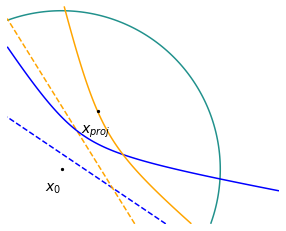

In [14]:
visualize(x_0, delta)